# Задание 1 (3 балла)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances

%matplotlib inline

2023-02-06 15:21:16.512735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
wiki = open('wiki_data.txt').read().split('\n')

In [3]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [4]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer() 

In [5]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token]
    return tokens

In [6]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [7]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 25:
        filtered_vocab.add(word)

In [8]:
len(filtered_vocab)

14147

In [9]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [12]:
vocab_size = len(id2word)

In [13]:
# skip gram negative sampling
def gen_batches_sg(sentences, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sentence in sentences:
            for center_word_index in range(len(sentence)):
                for win in range(-window, window+1):
                    contenx_word_index = center_word_index + win
                    if 0 <= contenx_word_index <= len(sentence)-1 and contenx_word_index != center_word_index:
                        context_word_ix = sentence[contenx_word_index]
                        X_target.append(sentence[center_word_index])
                        X_context.append(context_word_ix)
                        y.append(1)

                        X_target.append(sentence[center_word_index])
                        X_context.append(np.random.randint(vocab_size))
                        y.append(0)
                        
                        if len(X_target) >= batch_size:
                            X_target = np.array(X_target)
                            X_context = np.array(X_context)
                            y = np.array(y)
                            yield ((X_target, X_context), y)
                            X_target = []
                            X_context = []
                            y = []

In [14]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

2023-02-06 15:23:47.463511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 15:23:47.464842: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model.fit(gen_batches_sg(sentences[:19000], window=6),
          validation_data=gen_batches_sg(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
10000/10000 [==============================] - 594s 59ms/step - loss: 0.4469 - accuracy: 0.7999 - val_loss: 0.5196 - val_accuracy: 0.7720
Epoch 2/2
10000/10000 [==============================] - 613s 61ms/step - loss: 0.4243 - accuracy: 0.8175 - val_loss: 0.4960 - val_accuracy: 0.7862


In [16]:
embeddings_sg = model.layers[2].get_weights()[0]

In [17]:
most_similar('церковь', embeddings_sg)

['церковь',
 'святой',
 'храм',
 'православный',
 'монастырь',
 'собор',
 'освятить',
 'епархия',
 'придел',
 'епископ']

In [18]:
most_similar('школа', embeddings_sg)

['школа',
 'окончить',
 'учиться',
 'московский',
 'поступить',
 'университет',
 'училище',
 'факультет',
 'отделение',
 'техникум']

In [19]:
# cbow 
def gen_batches_cbow(sentences, window = 3, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sentence in sentences:
            for center_word_index in range(len(sentence)):
                context = []
                for win in range(-window, window+1):
                    contenx_word_index = center_word_index + win
                    if 0 <= contenx_word_index <= len(sentence)-1 and contenx_word_index != center_word_index:
                        context_word_ix = sentence[contenx_word_index]
                        context.append(context_word_ix)
                X_target.append(sentence[center_word_index])
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2, padding='post')
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [20]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.fit(gen_batches_cbow(sentences[:19000], window=3),
          validation_data=gen_batches_cbow(sentences[19000:],  window=3),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
5000/5000 [==============================] - 323s 64ms/step - loss: 0.3580 - accuracy: 0.8476 - val_loss: 0.3013 - val_accuracy: 0.8771
Epoch 2/2
5000/5000 [==============================] - 323s 65ms/step - loss: 0.2697 - accuracy: 0.8910 - val_loss: 0.2585 - val_accuracy: 0.8961


In [22]:
embeddings_cbow = model.layers[2].get_weights()[0]

In [23]:
most_similar('семья', embeddings_cbow)

['семья',
 'жить',
 'ребёнок',
 'отец',
 'родитель',
 'дом',
 'человек',
 'брат',
 'жена',
 'сестра']

In [24]:
most_similar('церковь', embeddings_cbow)

['церковь',
 'монастырь',
 'храм',
 'собор',
 'епархия',
 'церковный',
 'дом',
 'святой',
 'здание',
 'крепость']

**Вывод**: и skipgram, и cbow показывают хорошие результаты, оба нравятся.

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

## Word2Vec

In [25]:
import gensim

In [26]:
texts = [preprocess(text) for text in wiki]

In [27]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=350, 
                             min_count=25, 
                             max_vocab_size=14000,
                             window=6,
                             epochs=9,
                             sample=1e-5,
                             sg=1,
                             hs=1)

CPU times: user 2min 23s, sys: 117 ms, total: 2min 23s
Wall time: 48.8 s


In [28]:
w2v.wv.most_similar('церковь')

[('храм', 0.6726504564285278),
 ('освятить', 0.6634075045585632),
 ('собор', 0.6321802735328674),
 ('православный', 0.6275273561477661),
 ('святитель', 0.6126291751861572),
 ('приход', 0.5841184854507446),
 ('настоятель', 0.5789919495582581),
 ('епископ', 0.5725606083869934),
 ('святой', 0.5578508973121643),
 ('часовня', 0.555966854095459)]

Хорошо выглядит!

## FastText

In [29]:
%%time
ft = gensim.models.FastText(texts, min_n=4, max_n=10,
                            sg=0, hs=0,
                            negative=10,
                            vector_size=200, 
                            alpha=0.02, 
                            window=4, 
                            min_count=10,
                            ns_exponent=0.75)

CPU times: user 4min 6s, sys: 1.58 s, total: 4min 8s
Wall time: 1min 25s


In [30]:
ft.wv.most_similar('церковь')

[('«церковь', 0.9981598854064941),
 ('морковь', 0.9277918934822083),
 ('церкви»', 0.9190323352813721),
 ('храм', 0.8577026128768921),
 ('монастырь', 0.8554353713989258),
 ('архипастырь', 0.8373014330863953),
 ('собор', 0.8352756500244141),
 ('бахрам', 0.8238763809204102),
 ('святыня', 0.7910946607589722),
 ('шрам', 0.7888178825378418)]

Чуть странно, но ладно

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [31]:
data = pd.read_csv('labeled.csv')

In [32]:
data['norm_text'] = data.comment.apply(preprocess)

In [33]:
data.head()

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд-то, за, что, дебил, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч..."


In [34]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6308

In [35]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [36]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [37]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

## Тут простая модель без предобученных эмбеддингов

In [39]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

simple_model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
simple_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
simple_model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=15,
          callbacks=[callback])

Epoch 1/15
428/428 [==============================] - 2s 4ms/step - loss: 0.6147 - accuracy: 0.6598 - val_loss: 0.5767 - val_accuracy: 0.6505
Epoch 2/15
428/428 [==============================] - 1s 3ms/step - loss: 0.5158 - accuracy: 0.7226 - val_loss: 0.4773 - val_accuracy: 0.7448
Epoch 3/15
428/428 [==============================] - 2s 4ms/step - loss: 0.4148 - accuracy: 0.8350 - val_loss: 0.3995 - val_accuracy: 0.8336
Epoch 4/15
428/428 [==============================] - 1s 3ms/step - loss: 0.3478 - accuracy: 0.8755 - val_loss: 0.3598 - val_accuracy: 0.8433
Epoch 5/15
428/428 [==============================] - 1s 3ms/step - loss: 0.3050 - accuracy: 0.8926 - val_loss: 0.3369 - val_accuracy: 0.8627
Epoch 6/15
428/428 [==============================] - 1s 3ms/step - loss: 0.2744 - accuracy: 0.9069 - val_loss: 0.3233 - val_accuracy: 0.8779
Epoch 7/15
428/428 [==============================] - 2s 4ms/step - loss: 0.2501 - accuracy: 0.9140 - val_loss: 0.3266 - val_accuracy: 0.8488
Epoch 

## updated fasttext

In [41]:
%%time
ft_upd = gensim.models.FastText(texts + data['norm_text'].values.tolist(), 
                            min_n=4, 
                            max_n=10,
                            sg=0, 
                            hs=0,
                            negative=10,
                            vector_size=100, 
                            alpha=0.02, 
                            window=10,
                            epochs=10,
                            min_count=10,
                            ns_exponent=0.75)

CPU times: user 9min 36s, sys: 113 ms, total: 9min 36s
Wall time: 3min 15s


In [42]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[i] = ft_upd.wv[word]
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft_upd.wv['опрагпллирао']

In [43]:
inputs = tf.keras.layers.Input(shape=(100,))


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_ft = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_ft.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
model_ft.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=15,
          callbacks=[callback])

Epoch 1/15
428/428 [==============================] - 2s 4ms/step - loss: 0.5971 - accuracy: 0.6723 - val_loss: 0.5736 - val_accuracy: 0.6588
Epoch 2/15
428/428 [==============================] - 2s 4ms/step - loss: 0.5389 - accuracy: 0.7139 - val_loss: 0.5274 - val_accuracy: 0.7448
Epoch 3/15
428/428 [==============================] - 2s 4ms/step - loss: 0.4979 - accuracy: 0.7558 - val_loss: 0.4924 - val_accuracy: 0.7642
Epoch 4/15
428/428 [==============================] - 2s 4ms/step - loss: 0.4633 - accuracy: 0.7929 - val_loss: 0.4643 - val_accuracy: 0.7795
Epoch 5/15
428/428 [==============================] - 2s 4ms/step - loss: 0.4330 - accuracy: 0.8137 - val_loss: 0.4372 - val_accuracy: 0.8086
Epoch 6/15
428/428 [==============================] - 2s 4ms/step - loss: 0.4067 - accuracy: 0.8362 - val_loss: 0.4167 - val_accuracy: 0.8225
Epoch 7/15
428/428 [==============================] - 2s 4ms/step - loss: 0.3830 - accuracy: 0.8514 - val_loss: 0.4005 - val_accuracy: 0.8391
Epoch 

## not updated fasttext

In [45]:
weights = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[i] = ft.wv[word]
    
    except KeyError:
        continue
        weights[i] = ft.wv['опрагпллирао']

In [46]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, 
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [47]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=15)

Epoch 1/15
428/428 [==============================] - 3s 7ms/step - loss: 0.5958 - accuracy: 0.6665 - val_loss: 0.5764 - val_accuracy: 0.6588
Epoch 2/15
428/428 [==============================] - 3s 7ms/step - loss: 0.5332 - accuracy: 0.7110 - val_loss: 0.5174 - val_accuracy: 0.7309
Epoch 3/15
428/428 [==============================] - 3s 7ms/step - loss: 0.4676 - accuracy: 0.7882 - val_loss: 0.4590 - val_accuracy: 0.8294
Epoch 4/15
428/428 [==============================] - 3s 7ms/step - loss: 0.4095 - accuracy: 0.8370 - val_loss: 0.4120 - val_accuracy: 0.8350
Epoch 5/15
428/428 [==============================] - 3s 7ms/step - loss: 0.3631 - accuracy: 0.8685 - val_loss: 0.3795 - val_accuracy: 0.8280
Epoch 6/15
428/428 [==============================] - 3s 7ms/step - loss: 0.3271 - accuracy: 0.8855 - val_loss: 0.3572 - val_accuracy: 0.8558
Epoch 7/15
428/428 [==============================] - 3s 7ms/step - loss: 0.2992 - accuracy: 0.8987 - val_loss: 0.3486 - val_accuracy: 0.8350
Epoch 

## Word2Vec gensim

In [50]:
weights = np.zeros((len(word2id), 350))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]
    
    
    except KeyError:
        continue
        weights[i] = w2v.wv['опрагпллирао']

In [51]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=350, 
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_ft_ = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_ft_.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
model_ft_.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=15,
          callbacks=[callback])

Epoch 1/15
428/428 [==============================] - 6s 14ms/step - loss: 0.5845 - accuracy: 0.6777 - val_loss: 0.5166 - val_accuracy: 0.7046
Epoch 2/15
428/428 [==============================] - 6s 13ms/step - loss: 0.4231 - accuracy: 0.8225 - val_loss: 0.3829 - val_accuracy: 0.8696
Epoch 3/15
428/428 [==============================] - 6s 13ms/step - loss: 0.3198 - accuracy: 0.8868 - val_loss: 0.3382 - val_accuracy: 0.8890
Epoch 4/15
428/428 [==============================] - 6s 13ms/step - loss: 0.2680 - accuracy: 0.9043 - val_loss: 0.3192 - val_accuracy: 0.8849
Epoch 5/15
428/428 [==============================] - 6s 14ms/step - loss: 0.2342 - accuracy: 0.9179 - val_loss: 0.3120 - val_accuracy: 0.8766
Epoch 6/15
428/428 [==============================] - 6s 14ms/step - loss: 0.2068 - accuracy: 0.9280 - val_loss: 0.3410 - val_accuracy: 0.8724
Epoch 7/15
428/428 [==============================] - 6s 14ms/step - loss: 0.1858 - accuracy: 0.9326 - val_loss: 0.3144 - val_accuracy: 0.8779

## SkipGram

In [53]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[i] = embeddings_sg[word2id[word]]
    
    except KeyError:
        continue
        weights[i] = embeddings_sg['0098']

In [54]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_sg = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_sg.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
model_sg.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=15,
          callbacks=[callback])

Epoch 1/15
428/428 [==============================] - 5s 11ms/step - loss: 0.5874 - accuracy: 0.6750 - val_loss: 0.5318 - val_accuracy: 0.6727
Epoch 2/15
428/428 [==============================] - 5s 11ms/step - loss: 0.4270 - accuracy: 0.8182 - val_loss: 0.3933 - val_accuracy: 0.8003
Epoch 3/15
428/428 [==============================] - 5s 11ms/step - loss: 0.3225 - accuracy: 0.8848 - val_loss: 0.3386 - val_accuracy: 0.8863
Epoch 4/15
428/428 [==============================] - 5s 11ms/step - loss: 0.2680 - accuracy: 0.9064 - val_loss: 0.3167 - val_accuracy: 0.8738
Epoch 5/15
428/428 [==============================] - 5s 11ms/step - loss: 0.2329 - accuracy: 0.9168 - val_loss: 0.3181 - val_accuracy: 0.8682
Epoch 6/15
428/428 [==============================] - 5s 11ms/step - loss: 0.2075 - accuracy: 0.9243 - val_loss: 0.3174 - val_accuracy: 0.8766
Epoch 7/15
428/428 [==============================] - 5s 11ms/step - loss: 0.1868 - accuracy: 0.9327 - val_loss: 0.3172 - val_accuracy: 0.8807

## CBOW

In [56]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[i] = embeddings_cbow[word2id[word]]
    
    except KeyError:
        continue
        weights[i] = embeddings_cbow['0098']

In [57]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_cbow = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_cbow.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
model_cbow.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=15,
          callbacks=[callback])

Epoch 1/15
428/428 [==============================] - 5s 11ms/step - loss: 0.5975 - accuracy: 0.6691 - val_loss: 0.5543 - val_accuracy: 0.6616
Epoch 2/15
428/428 [==============================] - 5s 11ms/step - loss: 0.4597 - accuracy: 0.7880 - val_loss: 0.4113 - val_accuracy: 0.7989
Epoch 3/15
428/428 [==============================] - 5s 11ms/step - loss: 0.3464 - accuracy: 0.8738 - val_loss: 0.3557 - val_accuracy: 0.8266
Epoch 4/15
428/428 [==============================] - 5s 11ms/step - loss: 0.2904 - accuracy: 0.8977 - val_loss: 0.3266 - val_accuracy: 0.8530
Epoch 5/15
428/428 [==============================] - 5s 11ms/step - loss: 0.2531 - accuracy: 0.9094 - val_loss: 0.3204 - val_accuracy: 0.8807
Epoch 6/15
428/428 [==============================] - 5s 12ms/step - loss: 0.2261 - accuracy: 0.9226 - val_loss: 0.3110 - val_accuracy: 0.8807
Epoch 7/15
428/428 [==============================] - 5s 12ms/step - loss: 0.2050 - accuracy: 0.9267 - val_loss: 0.3219 - val_accuracy: 0.8696

## rus-vectores 

In [59]:
model = gensim.models.KeyedVectors.load_word2vec_format('news_upos_skipgram_300_5_2019/model.bin', binary=True)

In [60]:
mapping = {}

for line in open('ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [61]:
from pymystem3 import Mystem
m = Mystem()

In [62]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [63]:
data = pd.read_csv('labeled.csv')

In [64]:
data['norm_text'] = data.comment.apply(normalize_mystem)

In [65]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = model[word2id[word]]
    
    
    except KeyError:
        continue
        weights[i] = model['опрагпллирао']

In [66]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_vect = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_vect.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
model_vect.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=15,
          callbacks=[callback])

Epoch 1/15
428/428 [==============================] - 5s 10ms/step - loss: 0.5953 - accuracy: 0.6677 - val_loss: 0.5503 - val_accuracy: 0.6685
Epoch 2/15
428/428 [==============================] - 5s 12ms/step - loss: 0.4635 - accuracy: 0.7835 - val_loss: 0.4120 - val_accuracy: 0.8239
Epoch 3/15
428/428 [==============================] - 5s 12ms/step - loss: 0.3525 - accuracy: 0.8711 - val_loss: 0.3599 - val_accuracy: 0.8294
Epoch 4/15
428/428 [==============================] - 4s 10ms/step - loss: 0.2940 - accuracy: 0.8986 - val_loss: 0.3267 - val_accuracy: 0.8738
Epoch 5/15
428/428 [==============================] - 4s 10ms/step - loss: 0.2567 - accuracy: 0.9118 - val_loss: 0.3219 - val_accuracy: 0.8558
Epoch 6/15
428/428 [==============================] - 4s 10ms/step - loss: 0.2293 - accuracy: 0.9189 - val_loss: 0.3165 - val_accuracy: 0.8502
Epoch 7/15
428/428 [==============================] - 4s 10ms/step - loss: 0.2067 - accuracy: 0.9278 - val_loss: 0.3097 - val_accuracy: 0.8766

## Что лучше

In [68]:
def plot(model):
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xticks(range(len(model.history.history['val_accuracy'])), range(len(model.history.history['val_accuracy'])))
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

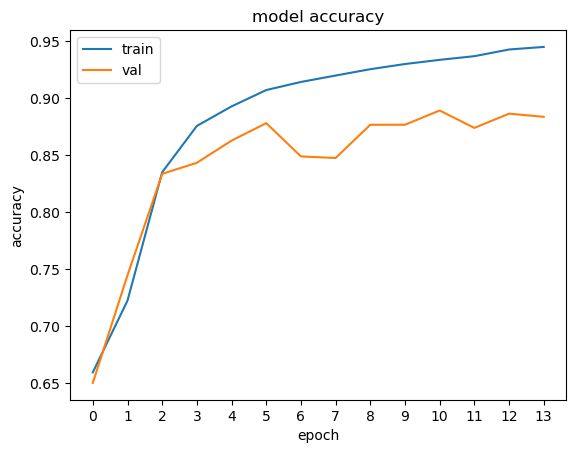

In [69]:
plot(simple_model) # без инициализации

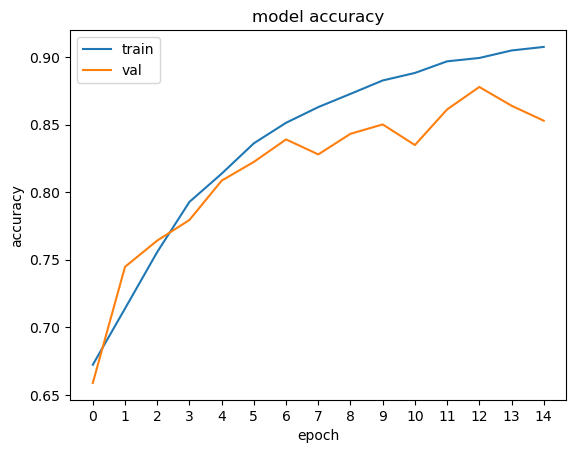

In [70]:
plot(model_ft) #first fasttext

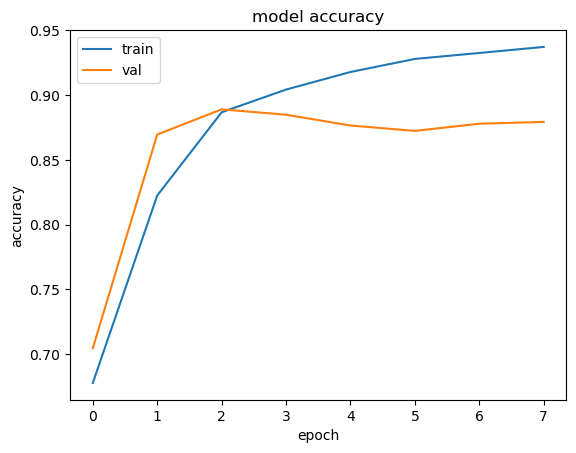

In [71]:
plot(model_ft_) # updated fasttext

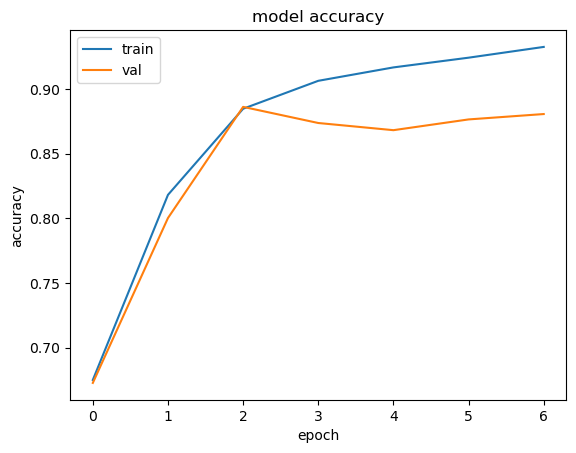

In [72]:
plot(model_sg) #skip gram

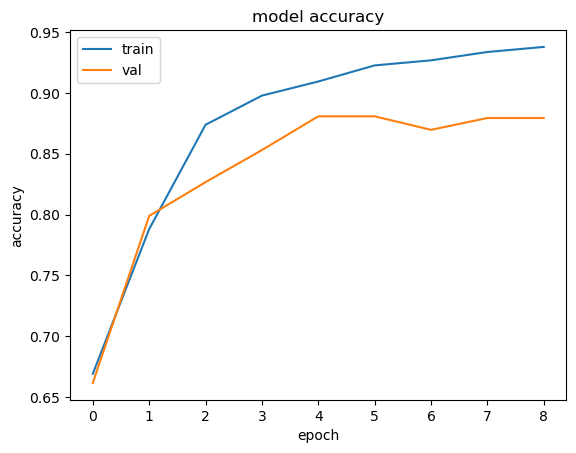

In [73]:
plot(model_cbow) #cbow

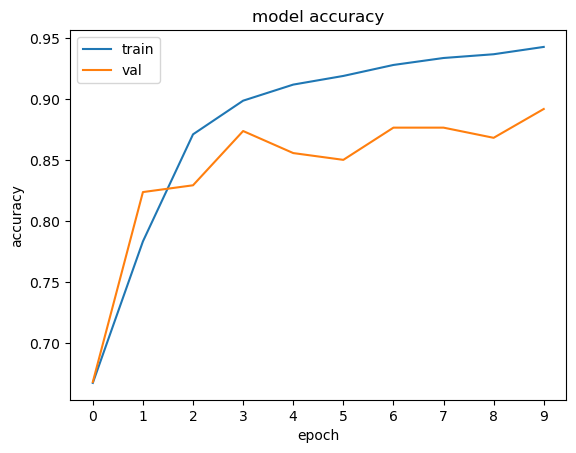

In [74]:
plot(model_vect) #rus_vectores

Видно, что модель с инициализацией rus_vectores показывает лучший результат, хотя остальные инициализации тоже выглядят неплохо! Везде val_accuracy > 0.85.